In [1]:
import sys
import gplately
import numpy as np
import gplately.pygplates as pygplates
from gplately import ptt
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from plate_model_manager import PlateModelManager

south_america_plate_id = 201
#anchor_plate_id = south_america_plate_id
anchor_plate_id = 0

In [2]:
%%capture cap
# Use PlateModelManager to download and manage files of the plate reconstruction models
pm_manager = PlateModelManager()
plate_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")

model = gplately.PlateReconstruction(plate_model.get_rotation_model(), 
                                     plate_model.get_topologies(), 
                                     plate_model.get_static_polygons(),
                                     anchor_plate_id=anchor_plate_id)
gplot = gplately.plot.PlotTopologies(model, 
                                     plate_model.get_layer('Coastlines'), 
                                     plate_model.get_layer('ContinentalPolygons'), 
                                     plate_model.get_layer('COBs'))

In [3]:
lat_samples = np.arange(-55,5,0.1)

# we are only interesed in the South America subduction zone in this notebook
# filter and keep the South America subduction zone data only
def get_south_america_subduction_zone_data(r12n_time):
    # Calculate subduction convergence stats with GPlately
    # Col. 0 - longitude of sampled trench point
    # Col. 1 - latitude of sampled trench point
    # Col. 2 - subducting convergence (relative to trench) velocity magnitude (in cm/yr)
    # Col. 3 - subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
    # Col. 4 - trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
    # Col. 5 - trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
    # Col. 6 - length of arc segment (in degrees) that current point is on
    # Col. 7 - trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
    # Col. 8 - subducting plate ID
    # Col. 9 - trench plate ID
    subduction_data = model.tessellate_subduction_zones(r12n_time, 
                                                        tessellation_threshold_radians=0.01, 
                                                        anchor_plate_id=anchor_plate_id,
                                                        ignore_warnings=True)
      
    ret=[]
    for row in subduction_data:
        if row[8] in [902,908,919,904,911,985,224,802] and (row[9]==201 or row[9]>200000): # code copied from Simon's original notebook
            ret.append(row)
    ret.sort(key=lambda row: row[1])
    ret_df = pd.DataFrame(ret, columns=['lon', 'lat', 'conv_rate', 'conv_angle', 'trench_velocity', 'trench_velocity_angle', 'arc_length',
                                     'trench_azimuth_angle', 'subducting_pid', 'trench_pid'])
    return ret_df[(ret_df.lat>lat_samples.min()) & (ret_df.lat<lat_samples.max())]


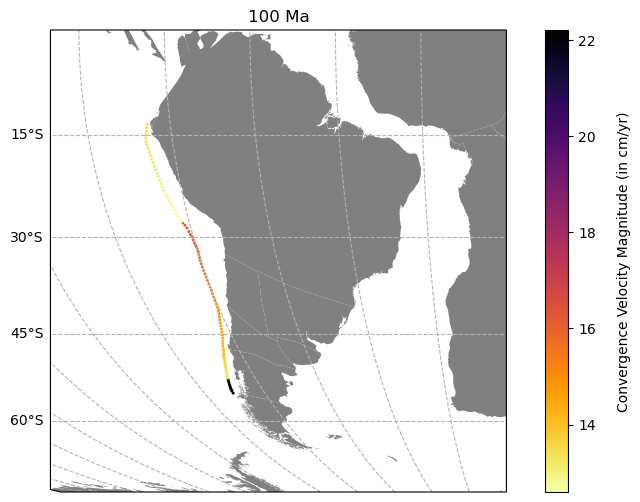

In [4]:
# plot the South America subduction zone sample points 
# the points are coloured by "subducting convergence (relative to trench) velocity magnitude (in cm/yr)"
reconstruction_time = 100
south_america_subduction_data = get_south_america_subduction_zone_data(reconstruction_time)
#print(south_america_subduction_data)

fig = plt.figure(figsize=(10,6), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))

gl=ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
gl.left_labels = True

plt.title(f'{reconstruction_time} Ma')
#ax.set_global()
ax.set_extent([-80,0,-70,0])

gplot.time = reconstruction_time
gplot.plot_coastlines(ax, color='grey')

# Latitudes and longitudes of points along trench segments
subduction_lon = south_america_subduction_data.lon
subduction_lat = south_america_subduction_data.lat

conv_rate = south_america_subduction_data.conv_rate # subducting convergence (relative to trench) velocity magnitude (in cm/yr)
cb=ax.scatter(subduction_lon,subduction_lat, marker=".", s=5, c=conv_rate, transform=ccrs.PlateCarree(), cmap="inferno_r")

cbar = plt.colorbar(cb)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Convergence Velocity Magnitude (in cm/yr)', rotation=90)
plt.show()

downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_Agegrids/Muller_etal_2019_Tectonics_v2.0_netCDF/Muller_etal_2019_Tectonics_v2.0_AgeGrid-100.nc
The local file(s) is/are still good. Will not download again at this moment.
building the spatial tree...


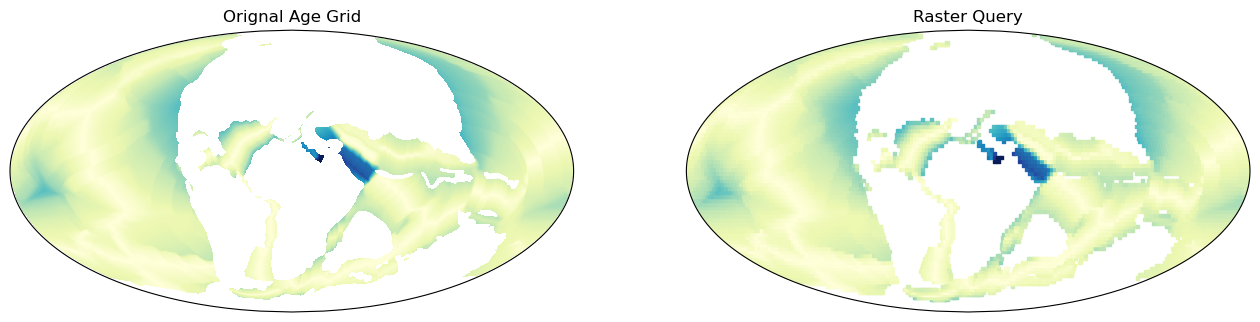

In [5]:
age_grid_raster = gplately.Raster(
    data=plate_model.get_raster("AgeGrids",100),
    plate_reconstruction=model,
    extent=[-180, 180, -90, 90],
    )

# plot the original age grid raster
fig = plt.figure(figsize=(16,8), dpi=100)
ax_1 = fig.add_subplot(121, projection=ccrs.Mollweide(central_longitude = 0))
age_grid_raster.imshow(ax=ax_1, cmap="YlGnBu",vmax=200, vmin=0)
ax_1.set_title("Orignal Age Grid")

# plot the data being retrieved by raster query
ax_2 = fig.add_subplot(122, projection=ccrs.Mollweide(central_longitude = 0))
xx, yy = np.meshgrid(np.linspace(-180, 180, 180), np.linspace(-90, 90, 90))
values = age_grid_raster.query(
        lons=xx.flatten(), lats=yy.flatten(),region_of_interest=10)
ax_2.scatter(
        xx.flatten(),
        yy.flatten(),
        c=values,
        marker="s",
        s=5,
        transform=ccrs.PlateCarree(),
        cmap="YlGnBu",
        vmax=200,
        vmin=0,
    )
ax_2.set_title("Raster Query")

plt.show()


In [6]:
def get_extent_from_data(data):
    x0 = data.lon.min()-2
    if x0<-180: x0=360+x0
    x1 = data.lon.max()+2
    if x1>180: x1=x1-360
    y0 = data.lat.min()-2
    if y0<-90: y0=180+y0
    y1 = data.lat.max()+2
    if y1>90: y1=y1-360
    return [x0,x1,y0,y1]

In [7]:
time_series = np.arange(0,121,1)

area_flux_series=[]
volume_flux_series=[]
age_array = []
conv_array = []
carbonate_array = []
for time in time_series:
    sa_sub_data = get_south_america_subduction_zone_data(time)
    conv_rate = sa_sub_data.conv_rate # subducting convergence (relative to trench) velocity magnitude (in cm/yr)
    conv_obliq = sa_sub_data.conv_angle # subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
    arc_length = sa_sub_data.arc_length # length of arc segment (in degrees) that current point is on
    # Latitudes and longitudes of points along trench segments
    subduction_lon = sa_sub_data.lon
    subduction_lat = sa_sub_data.lat

    ortho_conv_rate = conv_rate*np.abs(np.cos(np.radians(conv_obliq)))
    area_flux = ortho_conv_rate * 100. * arc_length * 2 * np.pi * 6371000. / 360. # formula copied from Simon's Notebook

    #
    # Query age grid rasters
    #
    age_grid_raster = gplately.Raster(
        data=plate_model.get_raster("AgeGrids",time),
        plate_reconstruction=model,
        extent=[-180, 180, -90, 90],
    )
    age_grid_raster=age_grid_raster.clip_by_extent(get_extent_from_data(sa_sub_data))
    ages = age_grid_raster.query(subduction_lon, subduction_lat,region_of_interest=200)

    #
    # Query carbonate sediment thickness rasters
    #
    carbonate_thickness_raster = gplately.Raster(
        data=plate_model.get_raster("SedimentThickness",time),
        plate_reconstruction=model,
        extent=[-180, 180, -90, 90],
    )
    carbonate_thickness_raster=carbonate_thickness_raster.clip_by_extent(get_extent_from_data(sa_sub_data))
    carbonate_thickness = carbonate_thickness_raster.query(subduction_lon, subduction_lat,region_of_interest=200)
    
    #
    # we have two methods to get the volume flux
    #
    # method 1: use gplately.tools.plate_isotherm_depth
    # plate_depth = [gplately.tools.plate_isotherm_depth(seafloor_age) for seafloor_age in ages]
    # volume_flux = area_flux * plate_depth 
    
    # method 2: use Simon's formula
    volume_flux = area_flux * np.sqrt(ages) * 10.  # UNITS????

    area_flux_series.append(area_flux.sum())
    volume_flux_series.append(np.nansum(volume_flux))

    conv_array.append(np.interp(lat_samples, subduction_lat, ortho_conv_rate, left=np.nan, right=np.nan))
    age_array.append(np.interp(lat_samples, subduction_lat, ages, left=np.nan, right=np.nan))
    carbonate_array.append(np.interp(lat_samples, subduction_lat, carbonate_thickness, left=np.nan, right=np.nan))
    

downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_Agegrids/Muller_etal_2019_Tectonics_v2.0_netCDF/Muller_etal_2019_Tectonics_v2.0_AgeGrid-0.nc
building the spatial tree...
downloading https://repo.gplates.org/webdav/pmm/muller2019/decompacted_sediment_thickness/decompacted_sediment_thickness_0.5_0.nc
building the spatial tree...
downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_Agegrids/Muller_etal_2019_Tectonics_v2.0_netCDF/Muller_etal_2019_Tectonics_v2.0_AgeGrid-1.nc
building the spatial tree...
downloading https://repo.gplates.org/webdav/pmm/muller2019/decompacted_sediment_thickness/decompacted_sediment_thickness_0.5_1.nc
building the spatial tree...
downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_Agegrids/Muller_etal_2019_Tectonics_v2.0_netCDF/Muller_etal_2019_Tectonics_v2.0_AgeGrid-2.nc
building the sp

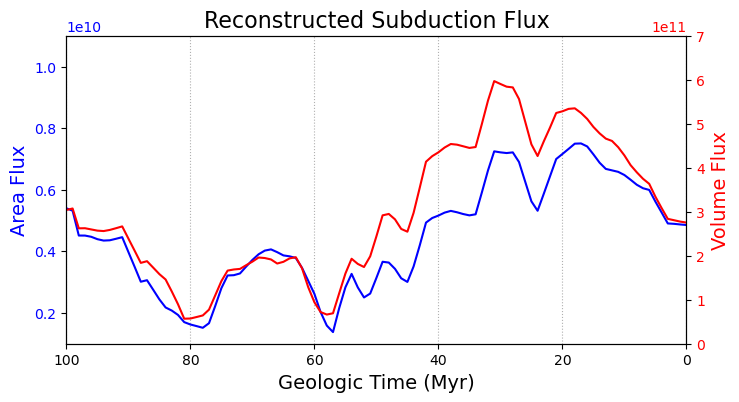

In [8]:
from scipy.ndimage import uniform_filter1d

fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

N=3
ax.plot(time_series, uniform_filter1d(area_flux_series, size=N), 'b', label='area flux')
ax.set_xlim(100,0)
ax.set_ylim(1e9,11e9)
ax.grid(axis='x', linestyle=':')
#ax.set_xticklabels([])
ax.set_ylabel('Area Flux', fontsize=14, color='b')
ax.tick_params(axis='y', labelcolor='b')

ax1 = ax.twinx() 
ax1.plot(time_series, uniform_filter1d(np.array(volume_flux_series), size=N), 'r', label='volume flux')
ax.set_xlabel('Geologic Time (Myr)', fontsize=14)
ax1.set_ylabel('Volume Flux', fontsize=14, color='r')
ax1.set_ylim(0e11,7e11)
ax1.tick_params(axis='y', labelcolor='r')
#ax.legend()
ax.set_title('Reconstructed Subduction Flux', fontsize=16)
plt.show()

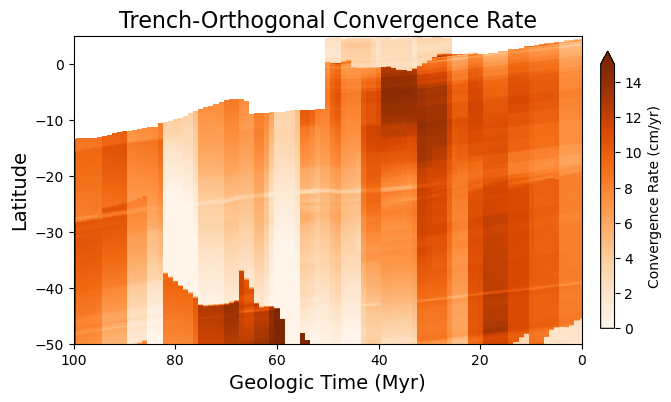

In [9]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

m = ax.pcolormesh(time_series, 
               lat_samples, 
               np.array(conv_array).T, 
               vmin=0, vmax=15, cmap='Oranges')

fig.colorbar(m, orientation="vertical", extend='max', shrink=0.9, pad=0.03, label='Convergence Rate [cm/yr]')

ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_xlabel('Reconstruction Time [Ma]', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Trench-Orthogonal Convergence Rate', fontsize=16)
plt.show()


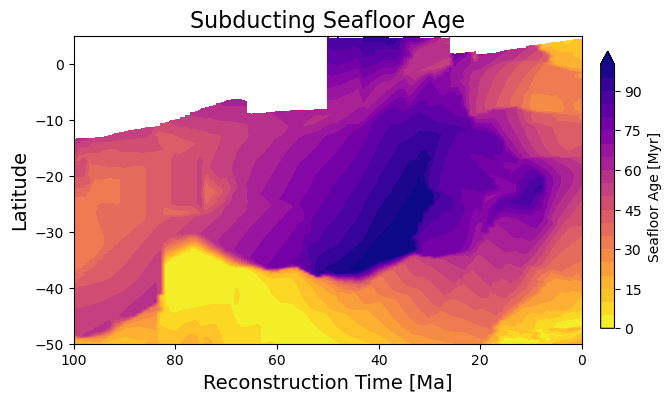

In [13]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

m = ax.contourf(time_series, 
               lat_samples, 
               np.array(age_array).T, 
               levels=np.arange(0,101,5), cmap='plasma_r', extend='max')

fig.colorbar(m, orientation="vertical", extend='max', shrink=0.9, pad=0.03, label='Seafloor Age [Myr]')

ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_xlabel('Reconstruction Time [Ma]', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Subducting Seafloor Age', fontsize=16)
plt.show()

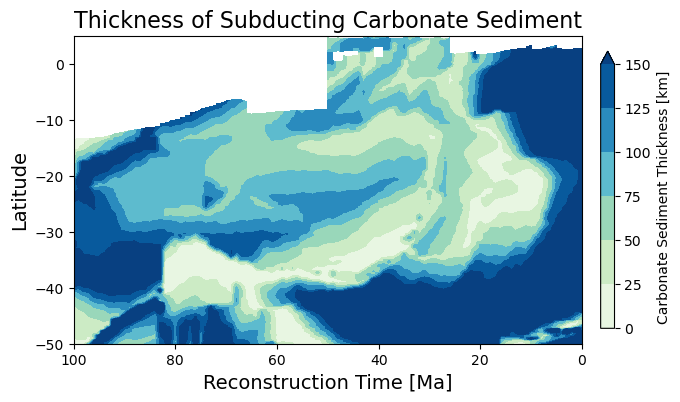

In [19]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

m = ax.contourf(time_series, 
               lat_samples, 
               np.array(carbonate_array).T, 
               levels=[0,25,50,75,100,125,150], vmax=150, cmap='GnBu', extend='max')

fig.colorbar(m, orientation="vertical", extend='max', shrink=0.9, pad=0.03, label='Carbonate Sediment Thickness [km]')

ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_xlabel('Reconstruction Time [Ma]', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Thickness of Subducting Carbonate Sediment', fontsize=16)
plt.show()